In [1]:
%matplotlib inline
from __future__ import unicode_literals, print_function, division
import re
import glob
import math
import time
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

use_cuda = torch.cuda.is_available()

## Data Preparation

In [2]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 10            
DATA_DIR = "./data"

    
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2
        
    def add_sentence(self, sentence):
        for word in sentence.split():
            self.add_word(word)
            
    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
            
def normalize_string(s):
    s = s.lower().strip()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


def pair_sentence_generator(data_dir, max_length):
    for f in glob.glob("{0}/*.txt".format(data_dir)):
        with open(f) as fhandle:
            lines = fhandle.readlines()
            for start, end in zip(lines, lines[1:]):
                start = normalize_string(start)
                end = normalize_string(end)
                if len(start.split()) < max_length and len(end.split()) < max_length:
                    yield start, end
                
                
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split()]


def variable_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result


def variables_from_pair(pair):
    input_variable = variable_from_sentence(input_lang, pair[0])
    target_variable = variable_from_sentence(output_lang, pair[1])
    return (input_variable, target_variable)


def prepare_data(data_dir, max_length=MAX_LENGTH):
    input_lang, output_lang = Lang("Input"), Lang("Output")
    pairs = []
    for start, end in pair_sentence_generator(data_dir, max_length):
        input_lang.add_sentence(start)
        output_lang.add_sentence(end)
        pairs.append([start, end])
    print("Total {0} sentences...".format(len(pairs)))
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs
    
    
# data preparation
input_lang, output_lang, pairs = prepare_data(DATA_DIR, MAX_LENGTH)
print(random.choice(pairs))

Total 1784192 sentences...
Counted words:
Input 75576
Output 75664
[u'that s your father yes .', u'abramovitch .']


## Seq2Seq Model

In [3]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def init_hidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result            

        
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_output, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]))
        return output, hidden, attn_weights

    def init_hidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result 

## Training the Model

In [4]:
teacher_forcing_ratio = 0.5


def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer,
          criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.init_hidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
    
    loss = 0
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_output, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_output, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.data[0] / target_length

In [5]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))


def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


def train_iters(encoder, decoder, pairs, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variables_from_pair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for i in range(n_iters):
        input_variable, target_variable = training_pairs[i]
        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if (i + 1) % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, (i + 1) / n_iters),
                                         i + 1, (i + 1) / n_iters * 100, print_loss_avg))
        if (i + 1) % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    show_plot(plot_losses)

6m 11s (- 365m 26s) (5000 1%) 4.7068
12m 13s (- 354m 45s) (10000 3%) 4.2750
18m 12s (- 346m 2s) (15000 5%) 4.1912
24m 18s (- 340m 21s) (20000 6%) 4.1025
30m 7s (- 331m 27s) (25000 8%) 4.0753
36m 3s (- 324m 27s) (30000 10%) 4.0426
42m 5s (- 318m 43s) (35000 11%) 4.0396
47m 58s (- 311m 50s) (40000 13%) 3.9804
53m 54s (- 305m 26s) (45000 15%) 3.9553
59m 44s (- 298m 44s) (50000 16%) 3.9656
65m 36s (- 292m 16s) (55000 18%) 3.9506
71m 20s (- 285m 21s) (60000 20%) 3.9649
77m 13s (- 279m 12s) (65000 21%) 3.9093
83m 3s (- 272m 55s) (70000 23%) 3.8861
89m 8s (- 267m 24s) (75000 25%) 3.9248
94m 59s (- 261m 12s) (80000 26%) 3.8687
100m 43s (- 254m 47s) (85000 28%) 3.8754
106m 35s (- 248m 43s) (90000 30%) 3.8162
112m 23s (- 242m 32s) (95000 31%) 3.8693
118m 5s (- 236m 11s) (100000 33%) 3.8148
123m 54s (- 230m 6s) (105000 35%) 3.7752
129m 47s (- 224m 11s) (110000 36%) 3.8712
135m 31s (- 218m 1s) (115000 38%) 3.7907
141m 25s (- 212m 8s) (120000 40%) 3.8257
147m 16s (- 206m 10s) (125000 41%) 3.8159
15

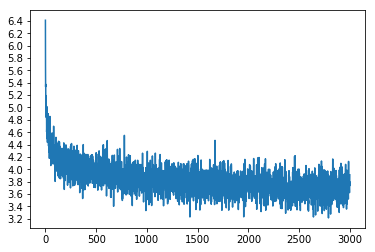

In [6]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, 1, dropout_p=0.1)

if use_cuda:
    encoder = encoder.cuda()
    attn_decoder = attn_decoder.cuda()
    
# train the mode
train_iters(encoder, attn_decoder, pairs, 300000, print_every=5000)

In [7]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variable_from_sentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.init_hidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_output, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    return decoded_words, decoder_attentions[:di + 1]


def evaluate_randomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        
        
# evaluate model 
evaluate_randomly(encoder, attn_decoder, n=1000)

> the right man wasn t right .
=  i ve been really trying baby 
< we il be right . <EOS>

> what s kicking basil ?
= a lot is kicking foxy .
< i . <EOS>

> somebody help !
= hey !
< help ! <EOS>

> yeah .
= i don t do hooks .
< i . <EOS>

> i didn t !
= i beg your pardon ?
< i was <EOS>

> poor guy .
= sounds like went into a lot of trouble .
< what s that ? <EOS>

> then what are we doin . . .
= would you let me finish ?
< we re the only way . <EOS>

> seaside pleasure and all that shagging around
= fall into your head she said what she said
< and that s all right <EOS>

> run away ?
= fuckin run away ?
< yes . <EOS>

> aruba s not that nice .
= excuse me ?
< i s <EOS>

> what ?
= little bit of traffic .
< what s <EOS>

> i fucking made it .
= i did it .
< i . <EOS>

> lovely legs .
= thank you .
< we il make it . <EOS>

> fuck !
= fuck !
< fuck ! <EOS>

> you re killing me .
= all right we got them .
< you re <EOS>

> you have a very beautiful wife .
= and who am i talking to ?
< i .

< i . <EOS>

> mm ?
= that was a close shave .
< yes . <EOS>

> music for chameleons .
= how did you know i wanted it ?
< i . <EOS>

> i m going home to my brats too .
= we re now approaching checkpoint two .
< i m <EOS>

> you il be tried before two courts .
= he s been tried !
< you . <EOS>

> what s in the basket ?
= hey tucker .
< what s <EOS>

> what have you done to me ?
= why can t i remember ?
< i . <EOS>

> you re all about to be poor again .
= think again .
< i . <EOS>

> hey do you know this guy ?
= nah i don t know him .
< i . <EOS>

> flash bangs body armor heat scopes .
= am i close ?
< i . <EOS>

> is it really double the price ?
= i can t pay double the price .
< yes . <EOS>

> congratulations .
= blessings .
< i . <EOS>

> you il do fine .
= you il do just fine .
< you . <EOS>

> go ask them jess .
= you hold it .
< what s that ? <EOS>

> good work !
= good work everyone !
< hey ! <EOS>

> stay here .
= i il be back .
< you . <EOS>

> i come here to see julien .
= he i


> isn t there someone else you can annoy ?
= friends ?
< i . <EOS>

> get him out of there !
= come on kid !
< you ! <EOS>

> do it .
= now get out of here .
< i . <EOS>

> they re here !
= what if we don t like him ?
< they re <EOS>

> woody !
= nice flash though .
< you ! <EOS>

> yeah .
= hello .
< i . <EOS>

> just iike you !
= who s shooting ?
< you ! <EOS>

> the rest of the night !
= driver are we staying here ?
< the is the <EOS>

> come on .
= it s not even that high .
< come on . <EOS>

> if i step here . . .
= very good .
< i . <EOS>

> the sirens are close now .
= she il be safe
< we re the <EOS>

> morning .
= good morning spud .
< morning . <EOS>

> i il tell you i m pretty excited .
= i mean nervous but i m excited .
< i m <EOS>

> neurotoxin .
= probably paralyzes their victim while they feed .
< i . <EOS>

> was it necessary ?
= had to be done .
< i was <EOS>

> i m killin you and him .
= you gonna kill me ?
< i m <EOS>

> what is it you want mr reich ?
= your skill o

< you . <EOS>

> chum !
= there you are bruce .
< hey ! <EOS>

> nice .
= what s on the program ?
< i . <EOS>

> here they come .
= let s get a shot .
< they . <EOS>

> you ve never lost your most beloved .
= i really want to see adele again .
< i . <EOS>

> seriously .
= seriously .
< you . <EOS>

> you re like an old woman .
= i have to stay here and work .
< i . <EOS>

> it s gotta reflect my style .
= the duke .
< i m <EOS>

> you hear me ?
= i hope you got it all .
< yes . <EOS>

> she came back with young okada
= with okada ?
< she s <EOS>

> and you have my bow .
= and my ax .
< i . <EOS>

> i know what i m doing .
= you listen to me .
< i m <EOS>

> you want me to come ?
= i don t know .
< i . <EOS>

> where are you from ?
= around .
< i m <EOS>

> joe s got . .
= yeah .
< i . <EOS>

> this whole thing is a farce .
= this whole thing is a farce .
< i . <EOS>

> she kissed me .
= what ?
< she . <EOS>

> all right settle down .
= yeah all right .
< i . <EOS>

> curien .
= i feel 

< yes . <EOS>

> you re drunk on that stuff .
= leave it be lorenzo barquero .
< you re <EOS>

> you understand ? i understand .
= right .
< i . <EOS>

> he s gonna turn don t do this !
=  screaming 
< he s <EOS>

> bancroft edward .
= bartlett roger .
< i . <EOS>

> you re going to start a riot .
= there you are good morning sunshine .
< you re <EOS>

> matt are you there ?
= pick up .
< i . <EOS>

> we re leaving .
= men give them their weapons .
< we re <EOS>

>  with the blood of patriots and tyrants . 
= thomas jefferson .
< and that s the . <EOS>

> here s your water .
= oh thank you hon .
< you . <EOS>

> yeth .
= pith .
< i . <EOS>

> let s go .
= elizabeth ?
< we re <EOS>

> come on !
= i see them !
< come on ! <EOS>

> have you considered that ?
= huh ?
< yes . <EOS>

> these tunnelsmustgo on formiles .
= he s here .
< we re . <EOS>

> my loves !
= you look wonderful .
< my god ! <EOS>

> roger that .
= star inbound .
< i . <EOS>

> grab it !
= i ve got it !
< you ! <EOS>

> 

< he s <EOS>

> quiet !
= come on y all .
< hey ! <EOS>

> what are you doing here dill ?
= you and shepherd ?
< i m <EOS>

> i always say look on the bright side !
= you re in the small ghetto .
< you re the <EOS>

> now !
= sendup ammunition forthe five inchguns !
< what ! <EOS>

> major i d like you to go along .
= yes ma am .
< i . <EOS>

> oh thank goodness .
= mama !
< i . <EOS>

> come on charlie .
= come on charlie .
< come on . <EOS>

> honey . . .
= my son . . .
< i . <EOS>

> we need to pull them in .
= sarah dishwasher !
< we . <EOS>

> i il allow it .
= what s the big deal ?
< i . <EOS>

> when you re right you re right .
= and you re right .
< you re . <EOS>

> human beings ain t only human .
= they got animals inside them too .
< i . <EOS>

> stop it !
= what a brat .
< stop ! <EOS>

> do you have something against anal burning ?
= what do you do in real life ?
< no . <EOS>

> good .
= i m glad .
< i . <EOS>

> all right then .
= all right kids .
< i . <EOS>

> that s pe

< you on ! <EOS>

> apaches win this game a whoosh !
= giants with me !
< you ! <EOS>

> we really have to do something about him
= asshole !
< we il <EOS>

> you look like a roast mutton .
= how are you doing mutton head ?
< i . <EOS>

> control
= your body your soul
< we re <EOS>

> be .
= what do you mean ?
< i . <EOS>

> you know i m here for you .
= they re saying vassili is dead .
< i m <EOS>

> sofa !
= what are you doing here ?
< hey ! <EOS>

> i m not through with you !
= what s the matter hank ?
< i m not <EOS>

> come on !
= oh !
< come on ! <EOS>

> you just cail .
= bye .
< you . <EOS>

> aah !
= don t be ridiculous bough .
< aah ! <EOS>

> that s pretty .
= where d you take that at ?
< i . <EOS>

> wingfield .
= you gotta understand .
< i . <EOS>

> back away .
= you open it .
< i . <EOS>

> skin knife .
= hold it mark .
< i . <EOS>

> say it !
= john shaft .
< it s <EOS>

> ah come here .
= oh .
< you . <EOS>

> what do i do ?
= just tag someone else and they re it !
< w